# Рабочий вариант курсовой работы

## Настройка ноутбука

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


MY_RANDOM = 427

## Определение функций

In [2]:
def create_lr_model(df, features):
    """ Создает модель линейной регрессии, делает прогноз на данных из df.
        Печатает оценки r2 и mse и возвращает кортеж из них
    """

    target = ['Price']

    X = pd.DataFrame(df[features])
    y = pd.DataFrame(df[target])

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=MY_RANDOM)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_valid)

    r2 = r2_score(y_valid, y_pred)
    mse = mean_squared_error(y_valid, y_pred)

    print(f'r2 = {r2}\nmse = {mse}')
    
    return (r2, mse)


In [3]:
def create_rf_model(df, features):
    """ Создает модель Random Forest, делает прогноз на данных из df.
        Печатает оценки r2 и mse и возвращает кортеж из них
    """

    target = ['Price']

    X = pd.DataFrame(df[features])
    y = pd.DataFrame(df[target])

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=MY_RANDOM)

    rf = RandomForestRegressor(n_estimators=100, random_state=MY_RANDOM)
    rf.fit(X_train, y_train.values.ravel())

    y_pred = rf.predict(X_valid)

    r2 = r2_score(y_valid, y_pred)
    mse = mean_squared_error(y_valid, y_pred)

    print(f'r2 = {r2}\nmse = {mse}')
    
    return (r2, mse)


## Данные

* **data_test** - test.csv
* **data_train** - train.csv
* **data_all** - совмещенные test и train (для анализа распределения, расчета производных значений, определения классов)
* **data_train_clear** - данные train которые будем очищать
* **data_test_clear** - данные test которые будем очищать
* **data_init** - данные для первичного предсказания

In [4]:
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')
data_all = pd.concat([data_test, data_train.drop(['Price'], axis=1)])
data_train_clear = data_train.copy()
data_test_clear = data_test.copy()

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [6]:
# Поле Healthcare_1 уберем, т.к. в нем слишком много пропущенных значений (боле 47%)
data_train_clear = data_train_clear.drop(['Healthcare_1'], axis=1)

In [7]:
# Строки переведем в числа (0 и 1)
data_train_clear.loc[data_train_clear['Ecology_2'] == 'B', 'Ecology_2'] = 1
data_train_clear.loc[data_train_clear['Ecology_2'] == 'A', 'Ecology_2'] = 0

data_train_clear.loc[data_train_clear['Ecology_3'] == 'B', 'Ecology_3'] = 1
data_train_clear.loc[data_train_clear['Ecology_3'] == 'A', 'Ecology_3'] = 0

data_train_clear.loc[data_train_clear['Shops_2'] == 'B', 'Shops_2'] = 1
data_train_clear.loc[data_train_clear['Shops_2'] == 'A', 'Shops_2'] = 0

In [8]:
# Для первичного предсказания заполним пропущенные значения по полю LifeSquare средним значением
data_init = data_train_clear.copy()
data_init.loc[:,'LifeSquare'] = data_init.loc[:,'LifeSquare'].fillna(data_train.LifeSquare.mean())

In [9]:
# Сделаем первичное предсказание и запомним начальные оценки точности

features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
            'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
            'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
            'Shops_1', 'Shops_2']

r2_lr, mse_lr = create_lr_model(data_init, features)

r2 = 0.367699524172983
mse = 5193081812.447669


In [10]:
r2_rf, mse_rf = create_rf_model(data_init, features)

r2 = 0.7354888530929022
mse = 2172429214.759466


In [11]:
# Пробуем убрать некоторые из признаков. Лучше всего модель показывает себя без признака LifeSquare

features_2 = [
                'DistrictId',     # 378 убрать
                'Rooms',          # 109 оставить, важный признак
                'Square',         # -1514 оставить, главный признак
#                 'LifeSquare',     # 450 убрать? почистить?
                'KitchenSquare',  # 372 убрать
                'Floor',          # 361 оставить
                'HouseFloor',     # 355 оставить
                'HouseYear',      # 372 убрать
                'Ecology_1',      # 360 оставить
                'Ecology_2',      # 375 убрать
                'Ecology_3',      # 372 убрать
                'Social_1',       # 391 убрать
                'Social_2',       # 374 убрать
                'Social_3',       # 372 убрать
                'Helthcare_2',    # 374 убрать
                'Shops_1',        # 380 убрать
                'Shops_2'         # 368 оставить
]

r2_without_LifeSquare_lr, mse_without_LifeSquare_lr = create_lr_model(data_init, features_2)

r2 = 0.4304206718699283
mse = 4677953224.358548


In [12]:
r2_without_LifeSquare_rf, mse_without_LifeSquare_lr = create_rf_model(data_init, features_2)

r2 = 0.7346500449448952
mse = 2179318343.431796


In [13]:
r2_init = r2_rf
mse_init = mse_rf

**Промежуточный вывод:** модель RandomForestRegressor работает намного лучше чем LinearRegression

# Убираем аномалии

In [14]:
data_train_clear.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


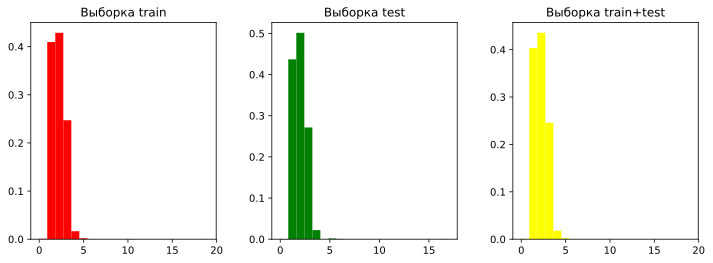

In [15]:
# Разберемся с полем Rooms
# Посмотрим на распределение в train, test, и общее

rooms_train = data_train['Rooms']
rooms_test = data_test['Rooms']
rooms_all = data_all['Rooms']

fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.flatten()

b=21
ax1.hist(rooms_train, bins=b, density=1, color='Red')
ax1.set_title('Выборка train')
ax2.hist(rooms_test, bins=b, density=1, color='Green')
ax2.set_title('Выборка test')
ax3.hist(rooms_all, bins=b, density=1, color='Yellow')
ax3.set_title('Выборка train+test')

fig.set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [16]:
# распределения похожи, все квартиры с Rooms > 5 и Rooms == 0 можно считать выбросами
# Посмотрим на количество таких квартир

In [17]:
data_train[data_train['Rooms'] == 0].shape[0]

8

In [18]:
data_test[data_test['Rooms'] == 0].shape[0]

2

In [19]:
data_train[data_train['Rooms'] > 5].shape[0]

4

In [20]:
data_test[data_test['Rooms'] > 5].shape[0]

3

In [21]:
data_train_clear[data_train_clear['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,1,1,11,3097,0,0,0,1,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,0,1,1,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,1,1,9,1892,0,0,1,1,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,1,1,30,6207,1,1,0,1,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,1,1,5,1564,0,0,0,1,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,0,0,1,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,1,1,43,8429,3,3,9,1,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,1,1,9,1892,0,0,1,1,219281.918007


In [22]:
# Таких квартир мало, можно поправить вручную
# квартира 12638 имеет аномальные значения площади, несоответсвие этажности
# посмотрим какая средняя площадь у квартир сданных в 2016 году в 27 районе
data_all.loc[(data_all['HouseYear'] == 2016)
                 & (data_all['DistrictId'] == 27)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     43.359842
2.0     66.580068
3.0     75.032881
4.0    104.664209
Name: Square, dtype: float64

In [23]:
data_train_clear.loc[data_train_clear['Id'] == 12638, 'Rooms'] = 5

In [24]:
data_all.loc[(data_all['HouseYear'] == 2008)
                 & (data_all['DistrictId'] == 27)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     45.201408
2.0     62.314663
4.0    140.242987
Name: Square, dtype: float64

In [25]:
data_train_clear.loc[data_train_clear['Id'] == 7917, 'Rooms'] = 6

In [26]:
data_all.loc[(data_all['HouseYear'] == 1977)
                 & (data_all['DistrictId'] == 27)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     42.732002
2.0     64.746627
3.0     77.572692
4.0    118.326205
5.0     42.003293
Name: Square, dtype: float64

In [27]:
data_train_clear.loc[data_train_clear['Id'] == 7317, 'Rooms'] = 1

In [28]:
data_all.loc[(data_all['HouseYear'] == 2015)
#                  & (data_all['DistrictId'] == 28)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     44.780814
2.0     64.813986
3.0     86.453313
4.0    122.619044
5.0    139.045763
Name: Square, dtype: float64

In [29]:
data_train_clear.loc[data_train_clear['Id'] == 770, 'Rooms'] = 1

In [30]:
data_all.loc[(data_all['HouseYear'] == 1977)
                 & (data_all['DistrictId'] == 6)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0    44.473549
2.0    63.143882
3.0    80.713766
Name: Square, dtype: float64

In [31]:
data_train_clear.loc[data_train_clear['Id'] == 456, 'Rooms'] = 3

In [32]:
data_all.loc[(data_all['HouseYear'] == 1977)
                 & (data_all['DistrictId'] == 27)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     42.732002
2.0     64.746627
3.0     77.572692
4.0    118.326205
5.0     42.003293
Name: Square, dtype: float64

In [33]:
data_train_clear.loc[data_train_clear['Id'] == 456, 'Rooms'] = 3

In [34]:
data_all.loc[(data_all['HouseYear'] == 1982)
                 & (data_all['DistrictId'] == 88)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0    39.546271
Name: Square, dtype: float64

In [35]:
data_train_clear.loc[data_train_clear['Id'] == 3159, 'Rooms'] = 1

In [36]:
data_all.loc[(data_all['HouseYear'] == 1977)
                 & (data_all['DistrictId'] == 27)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     42.732002
2.0     64.746627
3.0     77.572692
4.0    118.326205
5.0     42.003293
Name: Square, dtype: float64

In [37]:
data_train_clear.loc[data_train_clear['Id'] == 9443, 'Rooms'] = 3

In [38]:
data_train_clear[data_train_clear['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,0,0,1,126596.941798


In [39]:
data_train.loc[(data_train['HouseYear'] == 1977)
                 & (data_train['DistrictId'] == 27)
#                  & (data_train['Rooms'].isin([1, 2, 3, 4, 5]))
                 & (data_train['Price'] > 126596 - 1000)
                 & (data_train['Price'] < 126596 + 1000)].groupby(by=['Rooms'])['Rooms'].count()

Rooms
0.0    1
1.0    7
2.0    2
Name: Rooms, dtype: int64

In [40]:
data_train.loc[(data_train['HouseYear'] == 1977)
                 & (data_train['DistrictId'] == 27)
                 & (data_train['Rooms'] == 1)
                 & (data_train['Price'] > 126596 - 1000)
                 & (data_train['Price'] < 126596 + 1000)].groupby(by=['Rooms'])[['Square', 'LifeSquare']].mean()

,Square,LifeSquare
Rooms,,
1.0,42.155776,31.384296


In [41]:
data_train_clear.loc[data_train_clear['Id'] == 3224, 'Rooms'] = 1

In [42]:
data_train_clear.loc[data_train_clear['Id'] == 3224, 'Square'] = 42.155776

In [43]:
data_train_clear.loc[data_train_clear['Id'] == 3224, 'LifeSquare'] = 31.384296

In [44]:
data_train_clear[data_train_clear['Rooms'] == 0].shape[0]

0

In [45]:
# Теперь квартиры из test

In [46]:
data_test_clear[data_test_clear['Rooms'] == 0].shape[0]

2

In [47]:
data_test_clear[data_test_clear['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [48]:
data_all.loc[(data_all['HouseYear'] == 1977)
                 & (data_all['DistrictId'] == 58)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0    48.990231
2.0    66.863209
3.0    88.596786
Name: Square, dtype: float64

In [49]:
data_test_clear.loc[data_test_clear['Id'] == 3343, 'Rooms'] = 4

In [50]:
data_all.loc[(data_all['HouseYear'] == 1977)
                 & (data_all['DistrictId'] == 27)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     42.732002
2.0     64.746627
3.0     77.572692
4.0    118.326205
5.0     42.003293
Name: Square, dtype: float64

In [51]:
data_test_clear.loc[data_test_clear['Id'] == 10729, 'Rooms'] = 3

In [52]:
data_test_clear[data_test_clear['Rooms'] == 0].shape[0]

0

In [53]:
# Теперь квартиры с Rooms > 5

In [54]:
data_train_clear[data_train_clear['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,1,1,74,19083,2,5,15,1,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,1,1,1,264,0,0,1,1,78364.616704
1981,7917,27,6.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,0,1,1,302211.260887
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,1,1,66,10573,1,3,8,1,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,1,1,25,5648,1,2,4,1,172329.270863


In [55]:
data_all.loc[(data_all['HouseYear'] == 2002)
                 & (data_all['DistrictId'] == 57)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0    39.626493
2.0    61.542589
3.0    84.551764
Name: Square, dtype: float64

In [56]:
data_train_clear.loc[data_train_clear['Id'] == 5927, 'Rooms'] = 2

In [57]:
data_all.loc[(data_all['HouseYear'] == 2014)
                 & (data_all['DistrictId'] == 1)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0    45.911312
2.0    62.654172
3.0    78.320639
Name: Square, dtype: float64

In [58]:
data_train_clear.loc[data_train_clear['Id'] == 8491, 'Rooms'] = 1

In [59]:
data_all.loc[(data_all['HouseYear'] == 1969)
                 & (data_all['DistrictId'] == 99)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
2.0    45.464054
3.0    59.400041
Name: Square, dtype: float64

In [60]:
data_train_clear.loc[data_train_clear['Id'] == 14003, 'Rooms'] = 3

In [61]:
data_all.loc[(data_all['HouseYear'] == 1994)
                 & (data_all['DistrictId'] == 9)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0    39.293214
2.0    56.533960
3.0    75.944968
4.0    92.622516
Name: Square, dtype: float64

In [62]:
data_train_clear.loc[data_train_clear['Id'] == 14865, 'Rooms'] = 2

In [63]:
data_train_clear[data_train_clear['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,6.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,0,1,1,302211.260887


In [64]:
data_test_clear[data_test_clear['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [65]:
data_all.loc[(data_all['HouseYear'] == 2015)
                 & (data_all['DistrictId'] == 23)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     40.554445
2.0     58.875339
3.0     75.135014
4.0    110.621223
5.0    139.045763
Name: Square, dtype: float64

In [66]:
data_test_clear.loc[data_test_clear['Id'] == 10793, 'Rooms'] = 4

In [67]:
data_all.loc[(data_all['HouseYear'] == 2017)
                 & (data_all['DistrictId'] == 27)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0     45.557127
2.0     63.878111
3.0     97.248317
4.0    101.627637
Name: Square, dtype: float64

In [68]:
data_test_clear.loc[data_test_clear['Id'] == 4058, 'Rooms'] = 7

In [69]:
data_all.loc[(data_all['HouseYear'] == 1987)
#                  & (data_all['DistrictId'] == 111)
                 & (data_all['Rooms'].isin([1, 2, 3, 4, 5]))].groupby(by=['Rooms'])['Square'].mean()

Rooms
1.0    40.569792
2.0    56.921794
3.0    74.618064
4.0    79.415184
Name: Square, dtype: float64

In [70]:
data_test_clear.loc[data_test_clear['Id'] == 1435, 'Rooms'] = 2

In [71]:
# Правка по квартирам завершена
data_train_clear.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888900,56.319753,37.203513,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.813156,21.052298,86.240263,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.778555,22.774960,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


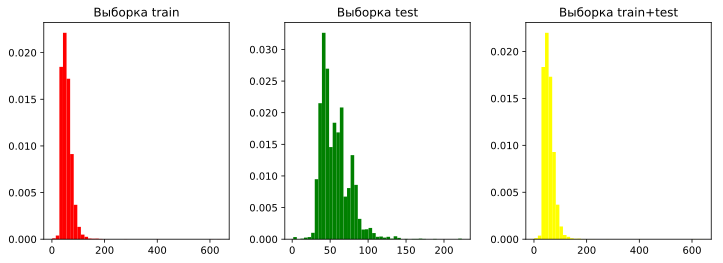

In [72]:
# Посмотрим распределение площадей
# Посмотрим на распределение в train, test, и общее

sq_train = data_train['Square']
sq_test = data_test['Square']
sq_all = data_all['Square']

fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.flatten()

b=47
ax1.hist(sq_train, bins=b, density=1, color='Red')
ax1.set_title('Выборка train')
ax2.hist(sq_test, bins=b, density=1, color='Green')
ax2.set_title('Выборка test')
ax3.hist(sq_all, bins=b, density=1, color='Yellow')
ax3.set_title('Выборка train+test')

fig.set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [73]:
# Выбросы > 250, причем на тесте таких нет. Посмотрим на эти квартиры.

data_train_clear[data_train_clear['Square'] > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,1,0,31,7010,5,3,7,1,455264.882666
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,1,1,25,5648,1,2,4,1,187717.242538
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,1,1,26,3889,6,3,6,1,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,1,1,22,6398,141,3,23,1,133529.681562


In [77]:
data_train_clear.loc[(data_train_clear['Square'] < 250)
                & (data_train_clear['Rooms'] == 5)
#                 & (data_train_clear['HouseYear'] == 2011)
                     ,
                     'Square'
                ].quantile(0.5)

116.08486083443316

In [79]:
data_train_clear.loc[data_train_clear['Id'] == 5548, 'Square'] = 116.084861

In [80]:
data_train_clear.loc[(data_train_clear['Square'] < 250)
                & (data_train_clear['Rooms'] == 2)
                & (data_train_clear['HouseYear'] == 1977),
                'Square'
                ].quantile(0.5)

63.640679169003505

In [82]:
data_train_clear.loc[data_train_clear['Id'] == 28, 'Square'] = 63.640679

In [83]:
data_train_clear.loc[(data_train_clear['Square'] < 250)
                & (data_train_clear['Rooms'] == 1)
                & (data_train_clear['HouseYear'] == 2016),
                'Square'
                ].quantile(0.5)

42.012315255143854

In [84]:
data_train_clear.loc[data_train_clear['Id'] == 2307, 'Square'] = 42.012315

In [85]:
data_train_clear.loc[(data_train_clear['Square'] < 250)
                & (data_train_clear['Rooms'] == 2)
                & (data_train_clear['HouseYear'] == 2019),
                'Square'
                ].quantile(0.5)

64.68290477848385

In [86]:
data_train_clear.loc[data_train_clear['Id'] == 11602, 'Square'] = 64.682905

In [101]:
data_train_clear['Square'].quantile(0.001)

5.4966935610906145

In [92]:
data_train_clear['Square'].min()

1.1368587776514651

In [103]:
# Выбросы < 20

data_train_clear[data_train_clear['Square'] < 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,1,1,43,8429,3,3,9,1,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,1,1,4,915,0,0,0,1,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,1,1,5,1564,0,0,0,1,137597.601458
1891,13685,0,1.0,17.498542,13.446544,0.0,7,5.0,1961,0.319809,1,1,25,4756,16,5,8,1,88871.750230
3166,15127,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,1,1,52,10311,6,1,9,1,74222.110465
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,1,1,9,1892,0,0,1,1,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,1,1,16,3433,4,4,5,1,369472.403061
3794,523,101,1.0,18.509177,15.170851,3.0,5,5.0,1970,0.225825,0,1,41,6558,7,3,2,1,115845.861527
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,1,1,25,4756,16,5,8,1,78388.806186
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,1,1,9,1892,0,0,1,1,161379.067034


In [106]:
data_train_clear.loc[data_train_clear['Rooms'] == 1, 'Square'].median()

40.411171927445395

In [108]:
data_train_clear.loc[(data_train_clear['Rooms'] == 1)
                     & (data_train_clear['Square'] < 10)
                     , 'Square'] = 40.411172

In [110]:
data_train_clear.loc[(data_train_clear['Square'] < 20)
                    & (data_train_clear['Rooms'] > 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,1,1,43,8429,3,3,9,1,412511.088764
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,1,1,25,4756,16,5,8,1,78388.806186
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,1,1,9,1892,0,0,1,1,161379.067034
5617,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,1,1,49,11395,3,3,4,0,77835.185808
6945,12927,62,2.0,17.414181,NaN,1.0,4,20.0,1977,0.072158,1,1,2,629,1,0,0,0,180750.471749
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,1,1,1,264,0,0,1,1,237716.681261


In [111]:
data_train_clear.loc[data_train_clear['Rooms'] == 2, 'Square'].median()

55.850302040779546

In [114]:
data_train_clear.loc[(data_train_clear['Rooms'] == 2)
                     & (data_train_clear['Square'] < 20)
                     , 'Square'] = 55.850302

In [115]:
data_train_clear.loc[(data_train_clear['Square'] < 20)
                    & (data_train_clear['Rooms'] > 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,1,1,25,4756,16,5,8,1,78388.806186
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,1,1,9,1892,0,0,1,1,161379.067034
5617,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,1,1,49,11395,3,3,4,0,77835.185808
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,1,1,1,264,0,0,1,1,237716.681261


In [116]:
data_train_clear.loc[data_train_clear['Rooms'] == 3, 'Square'].median()

77.4176922659957

In [117]:
data_train_clear.loc[(data_train_clear['Rooms'] == 3)
                     & (data_train_clear['Square'] < 20)
                     , 'Square'] = 77.417692

In [118]:
# Правка по Square завершена
data_train_clear.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888900,56.220799,37.203513,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.813156,18.944214,86.240263,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,1.000000,16.117154,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.784623,22.774960,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.539538,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.905349,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,6.000000,212.932361,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


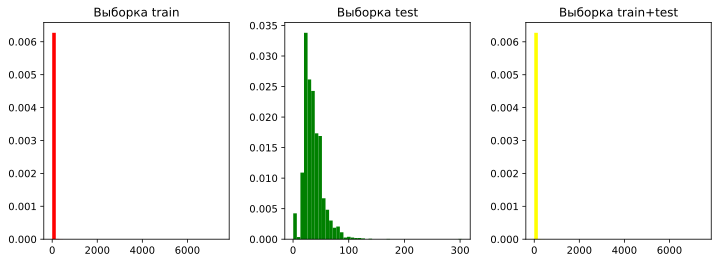

In [127]:
# Посмотрим распределение LifeSquare
# Посмотрим на распределение в train, test, и общее

lsq_train = data_train['LifeSquare']
lsq_test = data_test['LifeSquare']
lsq_all = data_all['LifeSquare']

fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.flatten()

b=47
ax1.hist(lsq_train, bins=b, density=1, color='Red')
ax1.set_title('Выборка train')
# ax1.set_xlim([0, 500])

ax2.hist(lsq_test, bins=b, density=1, color='Green')
ax2.set_title('Выборка test')

ax3.hist(lsq_all, bins=b, density=1, color='Yellow')
ax3.set_title('Выборка train+test')
# ax3.set_xlim([0, 300])

fig.set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [188]:
# похоже, что нормальные данные лежат в диапазоне от 15 до 200, попробуем найти среднее отношение жилой площади к общей

square_1r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                & (data_train_clear['Rooms'] == 1), 'Square']

lifesquare_1r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                     & (data_train_clear['Rooms'] == 1), 'LifeSquare']

life_square_coef_r1 = (lifesquare_1r / square_1r).sum() / lifesquare_1r.shape[0]


square_2r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                & (data_train_clear['Rooms'] == 2), 'Square']

lifesquare_2r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                     & (data_train_clear['Rooms'] == 2), 'LifeSquare']

life_square_coef_r2 = (lifesquare_2r / square_2r).sum() / lifesquare_2r.shape[0]


square_3r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                & (data_train_clear['Rooms'] == 3), 'Square']

lifesquare_3r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                     & (data_train_clear['Rooms'] == 3), 'LifeSquare']

life_square_coef_r3 = (lifesquare_3r / square_3r).sum() / lifesquare_3r.shape[0]


square_4r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                & (data_train_clear['Rooms'] == 4), 'Square']

lifesquare_4r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                     & (data_train_clear['Rooms'] == 4), 'LifeSquare']

life_square_coef_r4 = (lifesquare_4r / square_4r).sum() / lifesquare_4r.shape[0]


square_5r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                & (data_train_clear['Rooms'] == 5), 'Square']

lifesquare_5r = data_train_clear.loc[(data_train_clear['LifeSquare'] > 15) & (data_train_clear['LifeSquare'] < 200)
                                     & (data_train_clear['Rooms'] == 5), 'LifeSquare']

life_square_coef_r5 = (lifesquare_5r / square_5r).sum() / lifesquare_5r.shape[0]
life_square_coef_r5

0.7271187836009796

In [189]:
data_train_clear.loc[data_train_clear['Rooms'] == 1, 'LifeSquare'] = data_train_clear.loc[data_train_clear['Rooms'] == 1, 'LifeSquare'].fillna(data_train_clear.loc[data_train_clear['Rooms'] == 1,
                                                                                               'Square'] * life_square_coef_r1)
data_train_clear.loc[data_train_clear['Rooms'] == 2, 'LifeSquare'] = data_train_clear.loc[data_train_clear['Rooms'] == 2, 'LifeSquare'].fillna(data_train_clear.loc[data_train_clear['Rooms'] == 2,
                                                                                               'Square'] * life_square_coef_r2)
data_train_clear.loc[data_train_clear['Rooms'] == 3, 'LifeSquare'] = data_train_clear.loc[data_train_clear['Rooms'] == 3, 'LifeSquare'].fillna(data_train_clear.loc[data_train_clear['Rooms'] == 3,
                                                                                               'Square'] * life_square_coef_r3)
data_train_clear.loc[data_train_clear['Rooms'] == 4, 'LifeSquare'] = data_train_clear.loc[data_train_clear['Rooms'] == 4, 'LifeSquare'].fillna(data_train_clear.loc[data_train_clear['Rooms'] == 4,
                                                                                               'Square'] * life_square_coef_r4)
data_train_clear.loc[data_train_clear['Rooms'] == 5, 'LifeSquare'] = data_train_clear.loc[data_train_clear['Rooms'] == 5, 'LifeSquare'].fillna(data_train_clear.loc[data_train_clear['Rooms'] == 5,
                                                                                               'Square'] * life_square_coef_r5)

In [212]:
data_train_clear.loc[(data_train_clear['Rooms'] == 1)
                     & (data_train_clear['LifeSquare'] < 15),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 1)
                                                          & (data_train_clear['LifeSquare'] < 15),
                                                          'Square'] * life_square_coef_r1

data_train_clear.loc[(data_train_clear['Rooms'] == 2)
                     & (data_train_clear['LifeSquare'] < 15),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 2)
                                                          & (data_train_clear['LifeSquare'] < 15),
                                                          'Square'] * life_square_coef_r2

data_train_clear.loc[(data_train_clear['Rooms'] == 3)
                     & (data_train_clear['LifeSquare'] < 15),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 3)
                                                          & (data_train_clear['LifeSquare'] < 15),
                                                          'Square'] * life_square_coef_r3

data_train_clear.loc[(data_train_clear['Rooms'] == 4)
                     & (data_train_clear['LifeSquare'] < 15),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 4)
                                                          & (data_train_clear['LifeSquare'] < 15),
                                                          'Square'] * life_square_coef_r4

data_train_clear.loc[(data_train_clear['Rooms'] == 5)
                     & (data_train_clear['LifeSquare'] < 15),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 5)
                                                          & (data_train_clear['LifeSquare'] < 15),
                                                          'Square'] * life_square_coef_r5

In [215]:
data_train_clear.loc[(data_train_clear['Rooms'] == 1)
                     & (data_train_clear['LifeSquare'] > 200),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 1)
                                                          & (data_train_clear['LifeSquare'] > 200),
                                                          'Square'] * life_square_coef_r1

data_train_clear.loc[(data_train_clear['Rooms'] == 2)
                     & (data_train_clear['LifeSquare'] > 200),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 2)
                                                          & (data_train_clear['LifeSquare'] > 200),
                                                          'Square'] * life_square_coef_r2

data_train_clear.loc[(data_train_clear['Rooms'] == 3)
                     & (data_train_clear['LifeSquare'] > 200),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 3)
                                                          & (data_train_clear['LifeSquare'] > 200),
                                                          'Square'] * life_square_coef_r3

data_train_clear.loc[(data_train_clear['Rooms'] == 4)
                     & (data_train_clear['LifeSquare'] > 200),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 4)
                                                          & (data_train_clear['LifeSquare'] > 200),
                                                          'Square'] * life_square_coef_r4

data_train_clear.loc[(data_train_clear['Rooms'] == 5)
                     & (data_train_clear['LifeSquare'] > 200),
                     'LifeSquare'] = data_train_clear.loc[(data_train_clear['Rooms'] == 5)
                                                          & (data_train_clear['LifeSquare'] > 200),
                                                          'Square'] * life_square_coef_r5

In [219]:
features_3 = ['DistrictId',
             'Rooms',
             'Square',
             'LifeSquare',
#              'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
             'Ecology_2',
             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
             'Helthcare_2',
             'Shops_1',
             'Shops_2'
             ]

In [202]:
data_train_clear.loc[data_train_clear['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,1,1,30,6141,10,3,6,1,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,1,1,25,4756,16,5,8,1,243028.603096


In [204]:
data_train_clear.loc[data_train_clear['Id'] == 10814, 'HouseYear'] = 2005

In [205]:
data_train_clear.loc[data_train_clear['Id'] == 11607, 'HouseYear'] = 1968

In [227]:
data_train_clear.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888900,56.220799,37.628660,6.273300,8.526700,12.609400,1984.865700,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.813156,18.944214,16.384789,28.560917,5.241148,6.775974,18.411517,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,1.000000,16.117154,10.291332,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.784623,25.478190,1.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.539538,33.871174,6.000000,7.000000,13.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.905349,45.495974,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,6.000000,212.932361,211.231125,2014.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570


In [222]:
features

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [223]:
r2_current, mse_current = create_rf_model(data_train_clear, features)

r2 = 0.7399964876783087
mse = 2135408026.1354694


In [218]:
r2_init

0.7354888530929022

In [224]:
# почти 0.74, наши преобразования данных дали улучшений на:
r2_current - r2_init

0.004507634585406484

In [252]:
data_train_clear.corr(method='spearman')['Price'][data_train_clear.corr(method='spearman')['Price'] >= 0.3]

Rooms            0.597214
Square           0.569398
LifeSquare       0.445061
KitchenSquare    0.311176
Social_1         0.318099
Social_2         0.302016
Social_3         0.319785
Shops_1          0.311880
Price            1.000000
Name: Price, dtype: float64

In [253]:
features

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [255]:
features_corr = [
                 'DistrictId',
                 'Rooms',
                 'Square',
                 'LifeSquare',
                 'KitchenSquare',
#                  'Floor',
#                  'HouseFloor',
#                  'HouseYear',
#                  'Ecology_1',
#                  'Ecology_2',
#                  'Ecology_3',
                 'Social_1',
                 'Social_2',
                 'Social_3',
#                  'Helthcare_2',
                 'Shops_1',
#                  'Shops_2'
                ]

create_rf_model(data_train_clear, features_corr)

r2 = 0.7199039990833409
mse = 2300427571.554703


(0.7199039990833409, 2300427571.554703)

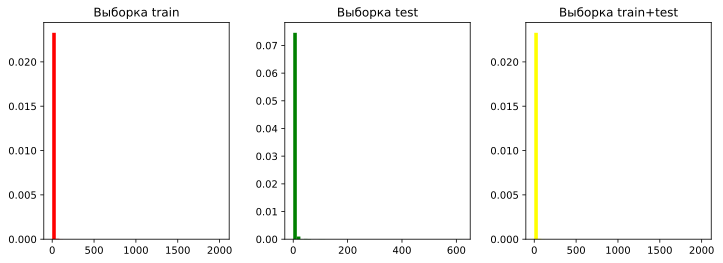

In [228]:
# Посмотрим распределение KitchenSquare
# Посмотрим на распределение в train, test, и общее

ksq_train = data_train['KitchenSquare']
ksq_test = data_test['KitchenSquare']
ksq_all = data_all['KitchenSquare']

fig, ax = plt.subplots(1, 3)
ax1, ax2, ax3 = ax.flatten()

b=47
ax1.hist(ksq_train, bins=b, density=1, color='Red')
ax1.set_title('Выборка train')
# ax1.set_xlim([0, 500])

ax2.hist(ksq_test, bins=b, density=1, color='Green')
ax2.set_title('Выборка test')

ax3.hist(ksq_all, bins=b, density=1, color='Yellow')
ax3.set_title('Выборка train+test')
# ax3.set_xlim([0, 300])

fig.set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [244]:
data_train_clear.loc[data_train_clear['KitchenSquare'] < 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,1,3,1,220925.908524
7,11993,74,2.0,80.312926,53.758678,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,0,2,1,221244.156664
8,5172,1,2.0,64.511437,43.181712,1.0,9,17.0,1977,0.007122,1,1,1,264,0,0,1,1,229102.795999
12,6452,13,2.0,54.522805,31.759753,1.0,8,12.0,1999,0.090799,1,1,74,19083,2,5,15,1,229220.372609
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,1,1,2,629,1,0,0,0,140647.565937
21,11935,27,2.0,64.711835,43.315851,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,0,1,1,127200.026511
23,6641,54,3.0,118.907612,81.818148,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,6,6,1,571069.052600
25,5073,74,2.0,82.667915,55.335026,1.0,16,17.0,1977,0.075779,1,1,6,1437,3,0,2,1,244145.827069
26,4378,27,3.0,106.958871,73.596439,0.0,17,0.0,2018,0.072158,1,1,2,629,1,0,0,0,337299.867936
27,7550,23,2.0,64.556209,43.211681,1.0,8,17.0,1977,0.075779,1,1,6,1437,3,0,2,1,173910.923723
